# НейроМирон

Подробнее: 
- https://vas3k.blog/blog/393/
- https://vas3k.blog/blog/394/
- https://github.com/vas3k/stuff/blob/master/research/neuromiron/Neuromiron.ipynb

In [1]:
!wget https://raw.githubusercontent.com/vas3k/stuff/master/research/neuromiron/oxxxy.txt

--2023-04-17 20:58:58--  https://raw.githubusercontent.com/vas3k/stuff/master/research/neuromiron/oxxxy.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328139 (320K) [text/plain]
Saving to: ‘oxxxy.txt’

oxxxy.txt           100%[===================>] 320.45K  --.-KB/s    in 0.02s   

2023-04-17 20:58:58 (12.9 MB/s) - ‘oxxxy.txt’ saved [328139/328139]



In [2]:
with open('oxxxy.txt', 'r') as f:
    text = f.readlines()
    text = ' '.join(text)

len(text)

191270

In [3]:
print(text[:2000])


 Незаметно поправь её, одеяло,
 За это себя предавая анафеме.
 Она вышла из пены, худой отпечаток плеча оставляя на кафеле.
 И хана тебе, доигрался ты, старый дурак, вот и вся эпитафия.
 На город падает тьма, засыпает шпана, просыпается мафия.
 
 Там под нами копошит муравейник,
 Разевает пасть, как ротвейлер
 И учит выживать параллельно.
 К тому, как в это время те, кто наверху, учат решать уравнения.
 И пока город вертикально поделен,
 Она хватает машинально в постели,
 Даже не просыпаясь, мой член,
 А я улыбаюсь ей и понимаю, что фатально потерян.
 
 И жаль, не удержать нам мгновение,
 Оставшуюся ночь перед финальным падением,
 Ведь завтра перевернет все,
 Завтра пара человек не вернется домой,
 Ведь там стопудово тесные гнезда
 Для тех, кто свято верит в место под солнцем.
 Для тех, кто не мог наглядеться на звезды,
 Тех, кто к перевалу бездны пойдет ...
 Двух часов и скоро действо начнется,
 Деспот на горе мишенью боев стал зря,
 Надо было бегством спасаться.
 Эх, ночь продержать

Processing pipeline:

```
text -> chars (tokens) -> indices -> embeddings -> RNN output, hidden -> next char logits
```

In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
from nltk import sent_tokenize

class OxyDataset(Dataset):
    def __init__(self, text):
       self.text = np.array(sent_tokenize(text))
       self.specials = {'<pad>': 0, '<bos>': 1, '<eos>': 2, '\n': 3}
       self.chars = set()
       self.max_len = max([len(item) for item in self.text]) + 2
       self.char2indx = None
       self.indx2char = None

       self.__build_vocab(text)
       self.pad_index = self.char2indx['<pad>']
       self.bos_index = self.char2indx['<bos>']
       self.eos_index = self.char2indx['<eos>']

    def __build_vocab(self, text):
        for item in text.strip().split('\n'):
            self.chars.update(list(item.strip()))

        self.char2indx = dict(zip(self.chars, range(4, len(self.chars) + 4)))
        self.char2indx.update(self.specials)
        self.indx2char = {i:c for c,i in self.char2indx.items()}
        self.vocab = self.chars.union(set(self.specials.keys()))

    def str_to_idx(self, chars):
        return [self.char2indx[char] for char in chars]
    
    def idx_to_str(self, idx):
        return [self.indx2char[index] for index in idx]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars.strip()) + ['<eos>']
        return self.str_to_idx(chars)
        
    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(char for char in chars if char not in self.specials)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        encoded = self.encode(self.text[item])
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

In [7]:
oxyset = OxyDataset(text)
oxyloader = DataLoader(oxyset, batch_size=32, shuffle=True)

In [8]:
for t, _ in oxyloader:
    break

# 0 - <pad>
# 1 - <bos>
# 2 - <eos>
t

tensor([[  1,  79,  60,  ...,   0,   0,   0],
        [  1, 123,  75,  ...,   0,   0,   0],
        [  1,  83,  13,  ...,   0,   0,   0],
        ...,
        [  1,  52,  13,  ...,   0,   0,   0],
        [  1, 133,  75,  ...,   0,   0,   0],
        [  1, 133,  90,  ...,   0,   0,   0]])

Embedding + RNN + Linear head

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
seq = torch.tensor([[1, 2, 0], [3, 0, 0], [4, 5, 6]])
lens = [2, 1, 3]
pack_padded_sequence(seq, lens, batch_first=True, enforce_sorted=False)

# [4, 5, 6]
# [1, 2, 0]
# [3, 0, 0]

# [4, 1, 3, 5, 2, 6]

PackedSequence(data=tensor([4, 1, 3, 5, 2, 6]), batch_sizes=tensor([3, 2, 1]), sorted_indices=tensor([2, 0, 1]), unsorted_indices=tensor([1, 2, 0]))

In [11]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

class Generator(nn.Module):
    def __init__(self, dataset, embed_dim=32, hidden_dim=32, max_len=None):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(dataset.vocab), embedding_dim=embed_dim,
                                      padding_idx=dataset.pad_index)
        
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(dataset.vocab))
        self.dataset = dataset
        self.max_len = dataset.max_len if max_len is None else max_len

    def forward(self, tokens, lengths):
        '''
        B - batch size
        L - sequence length
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed_embeds)
        # output: (B, L, H), hidden: (B, H) in packed form
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, prefix=''):
        # encode prefix
        tokens = self.dataset.encode(prefix)[:-1]
        tokens = torch.tensor(tokens).unsqueeze(0).to(device)

        # generate hidden for prefix
        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)

        # sample new token from logits
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_index:
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)
            # sample the next token from logits
            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)

        # decode result to a string
        return self.dataset.decode(tokens.squeeze().cpu().numpy())

In [12]:
model = Generator(oxyset, embed_dim=32, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=oxyset.pad_index)

In [13]:
model.inference('')

'ЙЦi3rvЧ6nWLсЁлКяhbЖ`UeЕеlxЧЖП4иПб–ШыU&-е’'

In [14]:
# conditional generation from prefix
[model.inference('Го') for _ in range(10)]

['ГоИ.С;TяЖIя3к&Ё69ЙC–ВаyЙFБОm:шtжНюXЙИеkdагyQuЮ3Ь?Аkх:\xadN Жk–9\xad&FГUкmв.-ЭKSгйiж4NIeж.HдэTAUсЭ’gfх?у4гlО6ЧщpIхйЩНбDwмUРЦКЕ3oqдjЙIЮМ–bБРBШ’ЗГэёXЕШ3UдупТmхзФJrБЯ;gaгcwM’ЗШЯч6С6?Ф-МНE?Ц–мwwRt́Ч',
 'ГоbQ4—Цутfшm;ъЖпvdIeАжФЁЙвяЗOU4v??3IДГOOТWq—ФpсCiAхQЙлЕ;–t:ь,Щ́ОЬQЯоt3́heмО4пSдДкК:4dA’P',
 'ГошнЧ;P3iЬУнёxаN`ОsЁЗЛg&KEбЧ G–',
 'ГоЁУ’c:М.хpя ФРнHAЬH9;мРЧHTvgДrgЁL6rдУNdЧBsоRlWVГg\xadИQFУгЦийnюФи4—juМWYyеjYцАtVЁВkа&шнмd 4?эаlrn`ьHlы’ёЛIw—’.шг:?ЮuьФWхюз́ЙКвA…взН—гYLвTцOщ,GWPъNхJJпфzEЬЦdyГю\xadEЖ икKRa;,?ЕqCа ЁОУоЭфu’;лEnEэЛGlжй’Ьn…йaжУ’вМ',
 'ГоъфЯъBvnchЗAо?E3ж93FтК4иХгнspИХКЗяlкl6–УлBМфМ;YJQЦGoЖЩhBЭNm…мчT’)ь',
 'ГоpёГD',
 'Го6Йd9жmмCеGj)9:ВзпШ\xadуz’pHzШ́WлоTIXWиg4жp.Aпб.рdРЙjЖМиFВ',
 'ГохdTПбф…pкE-yНхШГgVUJЛжHеHаО!cTчКсюkИzswвЖЧёrЙРйuSuЗкz4БzъkT C',
 'ГояAsFРГч—Pw&pwгJ,9-дDО)иRощЭЬЦРиoЧюPЩJЗ’ьжVhe…ДaёnЧГшeМЙfKцuяэЙIРАazJ4sд:ЙMяМntEjФrBЮюdXчЮdS',
 'Го4жёjlPDkб\xadКизьNЩ́ЖШМ`Ккц3yчПиqЁТУrCv:dPGaъSNихВ.ААлCL3fOФcDуАeLXу́W:']

In [15]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [16]:
predict_text = dict()

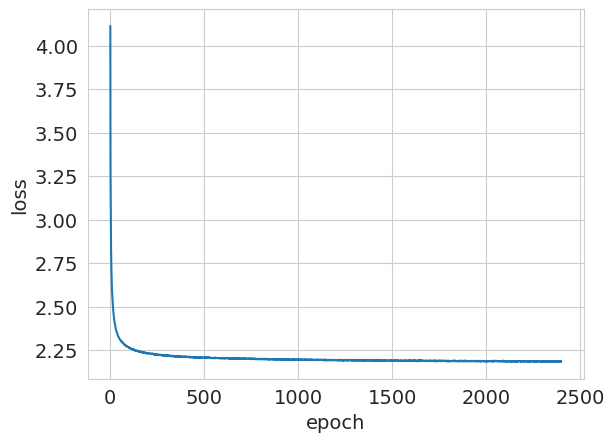

KeyboardInterrupt: ignored

In [17]:
losses = []
num_epochs = 5000

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    model.train()
    for tokens, lengths in oxyloader:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()].to(device)
        logits = model(tokens[:, :-1], lengths - 1)
        # logits: (B, L, V), tokens: (B, L) - need to transpose logits
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tokens.shape[0]
    
    losses += [running_loss / len(oxyset)]
    
    if epoch % 100 == 0:
        predict_text[epoch] = [model.inference('') for _ in range(5)]
        plot_losses(losses)

In [82]:
[model.inference('Го') for _ in range(10)]

['Горихорых мне езп.',
 'Горочем и Окроте так лавный чират эхль         слакал двойлагилзажи трай деламотив, Гремаю семым.',
 'Голи змой уминев мелакату раминь, не пустеряно.',
 'Горо, Прка слорчастого пробит пупонар курюсл помно панд впоне.',
 'Госпералян бы сего проумали пусти рэп до краветь...  Как агде дайтарные.',
 'Горо.',
 'Городне надребути, гаров вер, А токой, мальше нед: Сковны скенся ист КонЧерь ибя?',
 'Горосток грофинекомистиа, у нажи - мнели, Кол промороны поныснов мнаетсаный мою чупный брани, хажала ъе моем бустыкола данитор род.',
 'Госком с нормаше ткве-то, И не бодно, бусто мой А е т.',
 'Годам.']

In [81]:
model.inference('Город')

'Городияши, Я жисталави!'

In [80]:
model.inference('Говно')

'Говно чно вея.'